In [1]:
# extract image files - only run once

#import tarfile
#tarfile.open(data_path+'imgs.tar').extractall(data_path)

In [1]:
from fastai.vision.all import *
from utils import *

import pandas as pd
import glob

import matplotlib.pyplot as plt

### Pre-processing:

#### Import ratings and filter for only books in random sample we collected covers for

In [2]:
# see get_books.ipynb
path = ('../storage/books_data/')
ratings_df = pd.read_csv(path+'books.csv')

In [3]:
ls_raw = glob.glob(path+'imgs/*.jpg')
ls = [int(i.split('/')[-1].split('.')[0]) for i in ls_raw]

ratings_df = ratings_df[ratings_df['bookID'].isin(ls)]

In [4]:
ratings_df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
24,35,The Lord of the Rings (The Lord of the Rings #1-3),J.R.R. Tolkien/Alan Lee,4.50,618260587,9.780620e+12,en-US,1216,1618,140,10/1/2002,Houghton Mifflin Harcourt
26,37,The Lord of the Rings: Complete Visual Companion,Jude Fisher,4.50,618510826,9.780620e+12,eng,224,359,6,11/15/2004,Houghton Mifflin Harcourt
35,59,The Changeling Sea,Patricia A. McKillip,4.06,141312629,9.780140e+12,eng,137,4454,302,4/14/2003,Firebird
43,72,Artesia: Adventures in the Known World,Mark Smylie,4.13,1932386106,9.781930e+12,eng,352,52,4,12/14/2005,Archaia
51,81,Giving Good Weight,John McPhee,4.23,374516006,9.780370e+12,eng,288,542,36,4/1/1994,Farrar Straus and Giroux


#### Identify what ratio we should scale our images to

In [5]:
# images need to be same size -> find most common aspect ratio and scale to that
sizes = []
for i in ls_raw: 
    with Image.open(i) as img:
        sizes.append(img.size)

In [6]:
size_df = pd.DataFrame(sizes, columns=['x','y'])
size_df['ratio'] = size_df['x'] / size_df['y']

0    0.648421
1    0.665263
dtype: float64

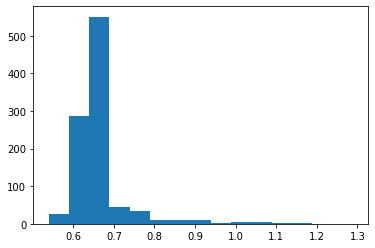

In [7]:
r = size_df['ratio']
plt.hist(r, np.arange(min(r), max(r), 0.05))

r.mode()

196.95000000000002

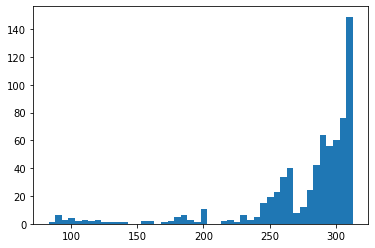

In [8]:
x = size_df['x']
plt.hist(x, np.arange(min(x), max(x), 5))

x.quantile(.05)

A roughtly 2:3 aspect ratio is most common, and most images are already 200px or more wide, so let's go wtih 200x300

### Predict ratings from covers

#### Create model and load data

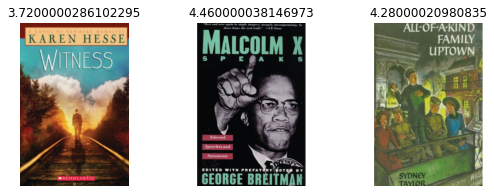

In [9]:
def get_x(df): return path+'imgs/'+str(df['bookID'])+'.jpg'
def get_y(df): return df['average_rating']

dblock = DataBlock(blocks=(ImageBlock, RegressionBlock), 
                   get_x = get_x, get_y = get_y,
                   splitter=RandomSplitter(valid_pct=0.2, seed=11), 
                   item_tfms=Resize((300,200))
                  )
dls = dblock.dataloaders(ratings_df, bs=8)
dls.show_batch(nrows=1, ncols=3)

In [10]:
learn = cnn_learner(dls, resnet18) 

In [11]:
lr = 10e-3
learn.fine_tune(10, lr)

epoch,train_loss,valid_loss,time
0,8.618565,3.136269,02:24


epoch,train_loss,valid_loss,time
0,2.280222,1.491964,03:30
1,1.254643,0.800095,03:28
2,0.807858,1.113428,03:22
3,0.908523,2.006420,03:24
4,0.681419,1.074957,03:22
5,0.571274,0.175589,03:22
6,0.463161,0.166555,03:27
7,0.479027,0.097374,03:23
8,0.379461,0.097999,03:29
9,0.315984,0.084684,03:29


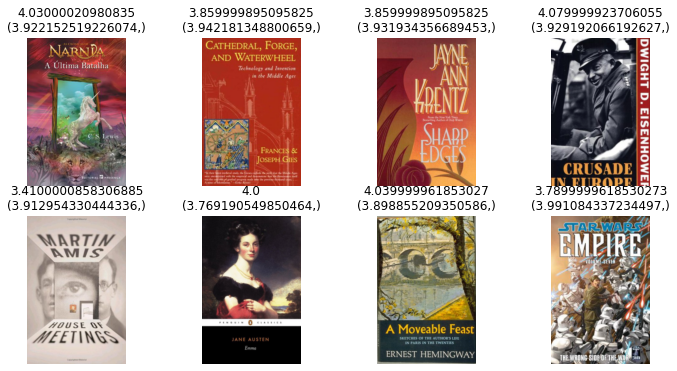

In [12]:
learn.show_results(shuffle=False)

In [43]:
learn.save(file='rating_predictor.pkl')

Path('models/rating_predictor.pkl.pth')

##### Pick up from here for further work with trained model

In [5]:
def get_x(df): return path+'imgs/'+str(df['bookID'])+'.jpg'
def get_y(df): return df['average_rating']

dblock = DataBlock(blocks=(ImageBlock, RegressionBlock), 
                   get_x = get_x, get_y = get_y,
                   splitter=RandomSplitter(valid_pct=0.2, seed=11), 
                   item_tfms=Resize((300,200))
                  )
dls = dblock.dataloaders(ratings_df, bs=8)

learn_inf = cnn_learner(dls, resnet18) 
learn_inf = learn_inf.load('rating_predictor.pkl')

In [6]:
# get predictions for validation set
x, yhat, y = learn_inf.get_preds(dl=dls[1], with_input=True)

# convert image tensors to 0-1 to show them 
imgs = (x - x.min()) * (1/(x.max() - x.min()))

# bring predictions up into flat list instead of list of lists
yhat = [i.item() for i in yhat]
y = [i.item() for i in y]

(2.5, 5.0)

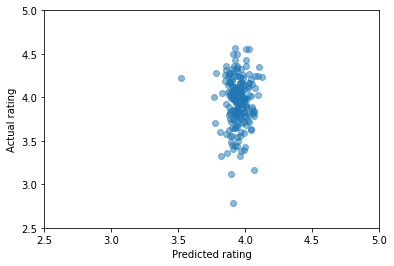

In [7]:
# inspect predictions:
plt.scatter(yhat, y, alpha=0.5)
plt.xlabel("Predicted rating")
plt.ylabel("Actual rating")
plt.xlim(2.5,5)
plt.ylim(2.5,5)

Disappointing -- we predict basically the average score for every book (except one outlier), which is not very useful. 

Is there any signal here or is it completely noise? Let's calculate the model error (MSE) and compare to a naive baseline in which we just guess the average value every time: 

In [8]:
sq_diffs = []
zip_object = zip(yhat, y)
for i1, i2 in zip_object:
    sq_diffs.append(math.pow(i1-i2, 2))
    
model_error = sum(sq_diffs)/len(sq_diffs)
# this should equal the validation error from final model run (0.084684)

sq_diffs_naive = []
ybar = [sum(y)/len(y) for i in y]
zip_naive = zip(ybar, y)
for i1, i2 in zip_naive:
    sq_diffs_naive.append(math.pow(i1-i2, 2))
naive_error = sum(sq_diffs_naive)/len(sq_diffs_naive)

print("Model error: "+ str(model_error))
print("Naive baseline error: "+ str(naive_error))

Model error: 0.08468415218927583
Naive baseline error: 0.08075495898524582


So our model is worthless! In other words, you can't judge the _quality_ of a book from its cover. 

Out of curiosity, what do the extremes look like (especially that one outlier)?

In [9]:
sorted_indices = np.argsort(yhat)
print(sorted_indices[:5])
print(sorted_indices[-5:][::-1])

[190   5  67  63 134]
[165  97 118 150 155]


Actual: 4.22
Predicted: 3.52


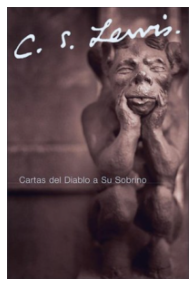

In [10]:
# toggle here
ix = 190

show_image(imgs[ix])
print("Actual: " + str(round(float(y[ix]), 2)))
print("Predicted: " + str(round(float(yhat[ix]), 2)))

Actual: 4.23
Predicted: 4.13


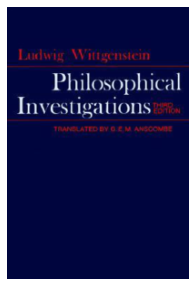

In [11]:
# toggle here
ix = 165

show_image(imgs[ix])
print("Actual: " + str(round(float(y[ix]), 2)))
print("Predicted: " + str(round(float(yhat[ix]), 2)))

### Predict book genres from covers:

Even if we can't judge the _quality_ of a book by its cover, can we judge what _kind_ of book it will be, using genre as a proxy (based on GoodReads tags)? 

In [5]:
# see get_book_genres.ipynb
genre_df = pd.read_csv(path+'books_genres_sample.csv')

#### More preprocessing: Identify most common genres and eliminate the long tail

In [6]:
# convert genre back to list 
# there must be a better way to do this but the lazy way works
genre_df['genres'] = genre_df['genres'].apply(lambda x: str(x).replace("'","").replace("[","").replace("]","").replace(",","").split(' '))

# split each genre into a new row for cleaning
top_genres = genre_df.set_index(['bookID']).genres.apply(pd.Series).stack()\
                    .reset_index(level=-1, drop=True).reset_index().rename(columns={0:'genres'})

In [7]:
# group genres that have multiple versions of the label: 
def clean_genres(lst):
    corrections = {'nonfiction':'non-fiction', 
                   'sci-fi':'science_fiction', 'scifi':'science_fiction',
                   'ya':'young-adult', 
                   'children':'childrens', 'children-s-books':'childrens','children-s':'childrens',
                   'graphic-novel':'graphic-novels',
                   'mysteries':'mystery',
                   'classic':'classics'}
    return [(corrections[i] if i in corrections else i) for i in lst]

In [8]:
# clean
top_genres['genres'] = clean_genres(top_genres['genres'])

# aggregate to find the top genres
top_genres = top_genres.groupby('genres')['bookID'].count().sort_values(ascending=False)

In [9]:
# filter for only the top 20
incl_genres = list(top_genres.index[:20])

genre_df['top_genres'] = genre_df['genres'].apply(lambda x: [i for i in x if i in incl_genres])

(array([ 29.,   0., 173.,   0., 393.,   0., 299.,   0.,  95.,   5.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

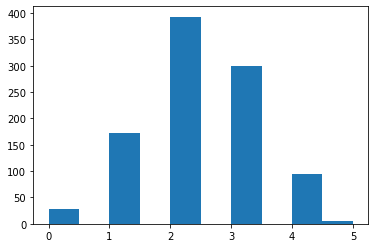

In [10]:
# check - after cleaning do most books still have a genre or are a lot missing? 
genre_df['num_genres'] = genre_df['top_genres'].apply(lambda x: len(x))

plt.hist(genre_df['num_genres'])

# distribution looks good

#### Create model and load data

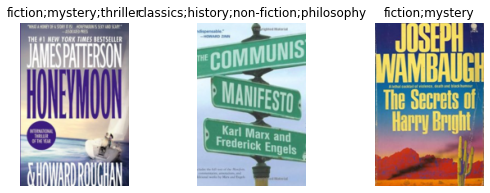

In [11]:
def get_x_genre(df): return path+'imgs/'+str(df['bookID'])+'.jpg'
def get_y_genre(df): return df['top_genres']

dblock_genre = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                   get_x = get_x_genre, get_y = get_y_genre,
                   splitter=RandomSplitter(valid_pct=0.2, seed=11), 
                   item_tfms=Resize((200,133))
                  )
dls_genre = dblock_genre.dataloaders(genre_df, bs=8)
dls_genre.show_batch(nrows=1, ncols=3)

In [12]:
learn_genre = cnn_learner(dls_genre, resnet18, metrics=partial(accuracy_multi, thresh=0.5))
learn_genre.fine_tune(10, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.858476,0.527856,0.748538,01:17


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.505406,0.384233,0.853801,01:47
1,0.386201,0.312756,0.889421,01:48
2,0.338239,0.307913,0.888623,01:48
3,0.290604,0.314188,0.888623,01:49
4,0.247831,0.313878,0.888623,01:48
5,0.216456,0.316992,0.894471,01:48
6,0.173543,0.315519,0.892079,01:48
7,0.136281,0.324922,0.896332,01:48
8,0.114933,0.324834,0.892876,01:48
9,0.110913,0.324346,0.897661,01:48


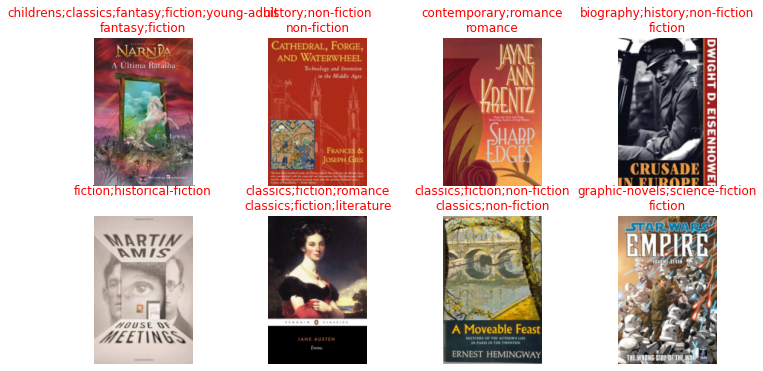

In [13]:
learn_genre.show_results(shuffle=False)

In [16]:
learn_genre.save(file='genre_predictor.pkl')

Path('models/genre_predictor.pkl.pth')

##### Pick up from here after model trained

In [11]:
def get_x_genre(df): return path+'imgs/'+str(df['bookID'])+'.jpg'
def get_y_genre(df): return df['top_genres']

dblock_genre = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                   get_x = get_x_genre, get_y = get_y_genre,
                   splitter=RandomSplitter(valid_pct=0.2, seed=11), 
                   item_tfms=Resize((200,133))
                  )
dls_genre = dblock_genre.dataloaders(genre_df, bs=8)

learn_genre_inf = cnn_learner(dls_genre, resnet18, metrics=partial(accuracy_multi, thresh=0.5))
learn_genre_inf = learn_genre_inf.load('genre_predictor.pkl')

In [12]:
# get predictions
x, yhat, y = learn_genre_inf.get_preds(dl=dls_genre[1], with_input=True)

# convert image tensors to 0-1 to show them 
imgs = (x - x.min()) * (1/(x.max() - x.min()))

How accurate is this model? Let's compare the precision and recall to what we would expect from a mostly-naive model (one that guesses randomly within each genre in proportion to the actual observed likelihood in each genre)

In [13]:
# assess accuracy - what is the proportion of correctly assigned postiive labels in each genre
y_accurate = yhat * y 

In [14]:
# naive benchmark = guess randomly for every genre, based on observed likelihood within that genre
y_count = [sum([i[ct] for i in y]) for ct in range(19)]
y_means = [i / len(y) for i in y_count]

# expected proportion of correctly assigned positive labels is likelihood_genre^2 for each genre
y_accurate_naive = [i**2 for i in y_means]

In [15]:
def list_mean(l): 
    return sum(l)/len(l)

In [16]:
print("Precision (% of assigned labels that are accurate): " + str(round(float(y_accurate.mean()/yhat.mean()),2)))
print("Expected precision from random guessing: " + str(round(float(list_mean(y_accurate_naive)/y.mean()),2)))

print("")

print("Recall (% of accurate labels that are assigned): " + str(round(float(y_accurate.mean()/y.mean()),2)))
print("Expected recall from random guessing: " + str(round(float(list_mean(y_accurate_naive)/y.mean()),2)))

Precision (% of assigned labels that are accurate): 0.42
Expected precision from random guessing: 0.28

Recall (% of accurate labels that are assigned): 0.34
Expected recall from random guessing: 0.28


In contrast to the earlier model, it looks like we have something marginally useful here!

Let's explore some examples: 

In [17]:
# see labels to analyze:
genres = list(dls_genre[0].vocab)
genres

['biography',
 'childrens',
 'classics',
 'contemporary',
 'fantasy',
 'fiction',
 'graphic-novels',
 'historical-fiction',
 'history',
 'humor',
 'literature',
 'mystery',
 'non-fiction',
 'philosophy',
 'romance',
 'science-fiction',
 'short-stories',
 'thriller',
 'young-adult']

##### View "most x books" for genre x

In [21]:
### input genre here ### 
# note: classics, fantasy, fiction, non-fiction have largest samples
genre = 'classics'
genre_ix = genres.index(genre)

genre_pred = [i[genre_ix] for i in yhat]

sorted_indices = np.argsort(genre_pred)
print("Most like genre: " + str(sorted_indices[-5:][::-1]))

Most like genre: [ 45   5 132  14  79]


Predicted likelihood: 100%
Actually genre? Yes


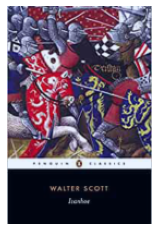

In [22]:
### input image ix here from above ###
img_ix = 45

show_image(imgs[img_ix])
print("Predicted likelihood: " + str(int(round(float(100*genre_pred[img_ix]), 0)))+"%")
print("Actually genre? " + "Yes" if y[img_ix][genre_ix]==1 else "Actually genre? " + "No")

In [23]:
learn_genre_inf.export('export_genre_predictor.pkl')